In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.observational.handlers.cut import SingleStageCut
from pyro.infer import Predictive

pyro.settings.set(module_local_params=True)

from cities.utils.data_grabber import DataGrabber

sns.set_style("white")

pyro.set_rng_seed(321) # for reproducibility

In [2]:
# Let's load the data from the author's github
DATA_URL = "https://raw.githubusercontent.com/synth-inference/synthdid/master/data/california_prop99.csv"
data = pd.read_csv(DATA_URL, sep=";")

# Assign unique integer ids for each state and each time
data["unit_index"] = pd.factorize(data["State"].values)[0]
data["time_index"] = pd.factorize(data["Year"].values)[0]

# Model below assumes the response is coded as "y"
data["y"] = data["PacksPerCapita"].values.copy()

# Assign each unit to treatment or control group
data["in_treatment_group"] = 0
treated_units = data[data["treated"] == 1]["State"].unique()
data.loc[data["State"].isin(treated_units), "in_treatment_group"] = 1
    

In [3]:
dg = DataGrabber()

dg.get_features_long(["gdp", 'population'])  #consider stdized

dg.long['gdp'].head()
analysis_data = pd.merge(dg.long['gdp'], dg.long['population'], on=['GeoFIPS', 'GeoName', 'Year'])
#print(analysis_data.columns[3:4])
analysis_data.rename(columns={'Value_x': 'gdp', 'Value_y': 'population'}, inplace=True)

analysis_data['unit_index']= pd.factorize(analysis_data['GeoFIPS'].values)[0]
analysis_data['time_index']= pd.factorize(analysis_data['Year'].values)[0]
analysis_data['y'] = analysis_data['gdp'].values.copy()


# some absurd pseudo-intervention for now
# so that 31 % states are "treated"
states_above_50000 = analysis_data[analysis_data['Year'] == 2015]['GeoFIPS'][analysis_data['population'] > 50000]
print(len(states_above_50000.unique())/len(analysis_data['GeoFIPS'].unique()))
analysis_data["treated"] = 0
analysis_data["in_treatment_group"] = 0
treated_mask = (analysis_data['GeoFIPS'].isin(states_above_50000))
unique_fips = analysis_data[treated_mask]['GeoFIPS'].unique()
deployment_mask = (analysis_data['GeoFIPS'].isin(unique_fips)) & (analysis_data['Year'] >= 2015)
analysis_data.loc[deployment_mask, 'treated'] = 1
in_treatment_mask = (analysis_data['GeoFIPS'].isin(unique_fips))
analysis_data.loc[in_treatment_mask, 'in_treatment_group'] = 1


analysis_data.sort_values(by='in_treatment_group', ascending=True, inplace=True)
analysis_data.reset_index(drop=True, inplace=True)

display(analysis_data.head())

def is_non_decreasing(numbers):
    for i in range(1, len(numbers)):
        if numbers[i] < numbers[i - 1]:
            return False
    return True

print("cigarette_data", is_non_decreasing(data['in_treatment_group'].values))
print("analysis_data", is_non_decreasing(analysis_data['in_treatment_group'].values))

0.3173575129533679


,GeoFIPS,GeoName,Year,gdp,population,unit_index,time_index,y,treated,in_treatment_group
0,56045,"Weston, WY",2010,94.247,7200.0,3087,9,94.247,0,0
1,8023,"Costilla, CO",2014,110.307,3398.0,235,12,110.307,0,0
2,8025,"Crowley, CO",2014,105.697,5689.0,236,12,105.697,0,0
3,8027,"Custer, CO",2014,106.093,4170.0,237,12,106.093,0,0
4,8029,"Delta, CO",2014,92.539,30034.0,238,12,92.539,0,0


cigarette_data False
analysis_data True


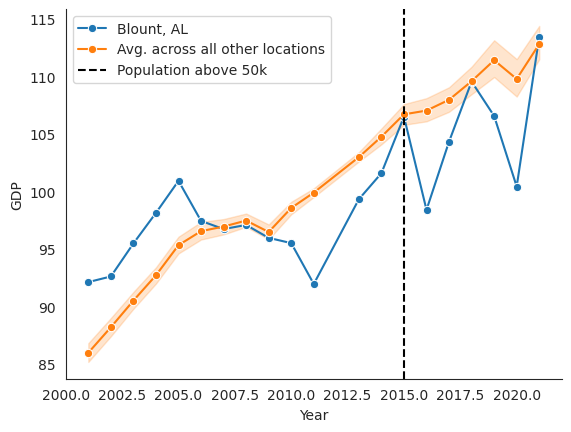

In [4]:
fips = 1009
outcome = "gdp"

sns.lineplot(
    x=analysis_data[analysis_data["GeoFIPS"] == fips]["Year"],
    y=analysis_data[analysis_data["GeoFIPS"] == fips][outcome],
    marker="o",
    label=analysis_data[analysis_data["GeoFIPS"] == fips]["GeoName"].unique()[0]
)

# The shaded area is the plot is the 95% confidence interval around the mean
sns.lineplot(
    x=analysis_data[analysis_data["GeoFIPS"] != fips]["Year"],
    y=analysis_data[analysis_data["GeoFIPS"] != fips][outcome],
    marker="o",
    label='Avg. across all other locations',
)

plt.axvline(
    2015, label="Population above 50k", color="black", linestyle="dashed"
)
plt.ylabel("GDP")
sns.despine()
plt.legend()

In [5]:
class BayesSDID(pyro.nn.PyroModule):
    def __init__(self, X: pd.DataFrame):
        """
        Input:
            X: dataframe with columns "unit_index", "time_index", "in_treatment_group", "y", "treated"
        """
        super().__init__()
        self.X = X.copy() 
        self.X.sort_values(by='in_treatment_group', ascending=True, inplace=True) # sorting needed, has impact on avg
        self.X.reset_index(drop=True, inplace=True)
        self.units_by_group = self.X[["unit_index", "in_treatment_group"]].drop_duplicates()
        self.N = self.units_by_group.shape[0] # number of units
        self.N_tr = self.units_by_group["in_treatment_group"].sum()  # number of treated units
        self.N_co = self.N - self.N_tr  # number of control units
        self.T_pre = self.X[self.X["treated"] == 1]["time_index"].min()  # number of pre-treatment periods
        self.T_post =self.X["time_index"].max() - self.T_pre + 1  # number of post-treatment periods
        self.T = len(self.X['time_index'].unique()) # total number of periods
        self.times_by_units = torch.tensor(pd.pivot_table(self.X, values="y", index="time_index", columns="unit_index").values).float()
        # average of each treated unit over the post-treatment period
        self.avg_y_post_treat = self.times_by_units[self.T_pre:, self.N_co:].mean(axis=0) 
        
        # average of each pre-treatment year across the treated units
        self.y_pre_treat_tr_avg = self.times_by_units[:self.T_pre, self.N_co:].mean(axis=1) 
        self.y = torch.tensor(self.X["y"].values)
        self.treated = torch.tensor(self.X["treated"].values)
        self.unit_index = list(self.X["unit_index"].values)
        self.time_index = list(self.X["time_index"].values)
        
    def _get_module_param(self, param, module_ix):
        if len(param.shape) > 1:
            return param[module_ix].squeeze()
        return param
    
    def sample_synthetic_control_weights(self):
        w0 = pyro.sample("w0", dist.Normal(0, 1)) # intercept
        w_co = pyro.sample("w_co", dist.Dirichlet(torch.ones(self.N_co))) # convex combination of control units
        return w0, w_co
    
    def sample_time_weights(self):
        lam_0 = pyro.sample("lam_0", dist.Normal(0, 10)) # intercept
        lam_pre = pyro.sample("lam_pre", dist.Dirichlet(torch.ones(self.T_pre))) # convex combination of time periods
        return lam_0, lam_pre
    
    def sample_response_params(self, prior_scale=10):
        # Intercept, time fixed effects, treatment effect, unit fixed effects 
        mu = pyro.sample("mu", dist.Normal(0, prior_scale))
        beta = pyro.sample("beta", dist.Normal(0, prior_scale).expand((self.T,)).to_event(1))
        tau = pyro.sample("tau", dist.Normal(0, prior_scale))
        alpha = pyro.sample( "alpha", dist.Normal(0, prior_scale).expand((self.N,)).to_event(1))
        return mu, beta, tau, alpha
    
    def synthetic_control_unit(self, times_by_units: torch.Tensor, w0: torch.Tensor, w_co: torch.Tensor):
        return w0 + times_by_units.mv(w_co)
    
    def time_control(self, units_by_time: torch.Tensor, lam_0, lam_pre):
        return lam_0 + units_by_time.mv(lam_pre)
    
    def forward(self, **kwargs):        
        # Sample synthetic control weights, time weights, response parameters
        w0, w_co = self.sample_synthetic_control_weights()
        _shape_w_tr = list(w_co.shape)
        _shape_w_tr[-1] = self.N_tr
        w_co_tr = torch.cat([w_co, 1 / self.N_tr * torch.ones(_shape_w_tr)], axis=-1) # TODO: this assumes
        lam_0, lam_pre = self.sample_time_weights()
        _shape_lam_post = list(w_co.shape)
        _shape_lam_post[-1] = self.T_post
        lam_pre_post = torch.cat([lam_pre, 1 / self.T_post * torch.ones(_shape_lam_post)], axis=-1) # TODO: this assumes
        
        mu, beta, tau, alpha = self.sample_response_params()
        
        y_sc = self.synthetic_control_unit(
                self.times_by_units[:self.T_pre, :self.N_co], 
                self._get_module_param(w0, 0),
                self._get_module_param(w_co, 0)
            )
        
        
        with pyro.plate("synthetic_control_weights", self.T_pre):
            pyro.sample("y_pre_treat_tr_avg", dist.Normal(y_sc, 1.0), obs=self.y_pre_treat_tr_avg)
        
        # Time weights likelihood
        y_time = self.time_control(
            self.times_by_units[:self.T_pre, :].T, 
            self._get_module_param(lam_0, 0),
            self._get_module_param(lam_pre, 0)
        )
        
        
        # something's off with broadcasting here
        print("but wait", self.avg_y_post_treat.shape)
        with pyro.plate("time_weights", self.N):
            avg_y_post = pyro.sample("avg_y_post_treat", dist.Normal(y_time, 1.0), obs=self.avg_y_post_treat)
            
        print("avg_y_post", avg_y_post.shape)
        
        # Response likelihood
        # Here we use the copy of module one parameters to response likelihood to change module one 
        # gradients
        weights = self._get_module_param(w_co_tr, 1)[self.unit_index] * self._get_module_param(lam_pre_post, 1)[self.time_index]
        f = self._get_module_param(mu, 1) + self._get_module_param(beta, 1)[self.time_index] + self._get_module_param(alpha, 1)[self.unit_index] + self._get_module_param(tau, 1) * self.treated
        with pyro.plate("response", self.N * self.T):
            response = pyro.sample("y", dist.Normal(f, 1 / weights), obs=self.y)
            
        print("response", response.shape)

sdid = BayesSDID(analysis_data)


In [6]:
w0, w_co = sdid.sample_synthetic_control_weights()
lam_0, lam_pre = sdid.sample_time_weights()
mu, beta, tau, alpha = sdid.sample_response_params()


print(
"N",    sdid.N,
"N_tr", sdid.N_tr,
"N_co", sdid.N_co,
"T_pre", sdid.T_pre,
"T_post", sdid.T_post,
"T", sdid.T,
"times_by_units", sdid.times_by_units.shape,  
"avg_y_post", sdid.avg_y_post_treat.shape,
"y_pre_treat_tr_avg", sdid.y_pre_treat_tr_avg.shape,
"y", sdid.y.shape, 
"treated", sdid.treated.shape,
"unit_index", len(sdid.unit_index),
"time_index", len(sdid.time_index),
"w0", w0,
"w_co", w_co.shape,
"lam_0", lam_0,
"lam_pre", lam_pre.shape,
"mu", mu,
"beta", beta.shape,
"tau", tau,
"alpha", alpha.shape,
)


print(sdid.times_by_units[:sdid.N_co].shape)

#display(w0 + sdid.times_by_units[:sdid.N_co,].mv(w_co))

sdid.forward()



N 3088 N_tr 980 N_co 2108 T_pre 13 T_post 7 T 20 times_by_units torch.Size([20, 3088]) avg_y_post torch.Size([980]) y_pre_treat_tr_avg torch.Size([13]) y torch.Size([61760]) treated torch.Size([61760]) unit_index 61760 time_index 61760 w0 tensor(-1.1353) w_co torch.Size([2108]) lam_0 tensor(25.4957) lam_pre torch.Size([13]) mu tensor(-4.0462) beta torch.Size([20]) tau tensor(10.0740) alpha torch.Size([3088])
torch.Size([20, 3088])
but wait torch.Size([980])


ValueError: Shape mismatch inside plate('time_weights') at site avg_y_post_treat dim -1, 2108 vs 3088

In [7]:
# Define a helper function to run SVI.
def run_svi_inference(model, n_steps=100, verbose=True, lr=.03, vi_family=AutoNormal, guide=None, **model_kwargs):
    if guide is None:
        guide = vi_family(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, n_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 1000 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

In [8]:
joint_guide = run_svi_inference(BayesSDID(analysis_data), vi_family=AutoNormal, n_steps=5000)

# Get posterior samples from the joint guide
#joint_samples = Predictive(BayesSDID(analysis_data), guide=joint_guide, num_samples=1000)()

[iteration 0001] loss: 676647.6111


ValueError: Error while computing log_prob at site 'w_co':
Expected value argument (Tensor of shape (2108,)) to be within the support (Simplex()) of the distribution Dirichlet(concentration: torch.Size([2108])), but found invalid values:
tensor([0.0006, 0.0006, 0.0006,  ..., 0.0005, 0.0005, 0.0005],
       grad_fn=<ExpandBackward0>)
Trace Shapes:       
 Param Sites:       
Sample Sites:       
      w0 dist |     
        value |     
     log_prob |     
    w_co dist | 2108
        value | 2108

In [ ]:
# It seems that you are trying to perform element-wise multiplication between two tensors, but the sizes of these tensors are not compatible. The error message indicates that the size of w_co_tr at dimension 0 is 61760, while the size of lam_pre_post at dimension 0 is 1209. These sizes should match if you want to perform element-wise operations between them.

# To resolve this issue, you need to ensure that the dimensions of these tensors align correctly for element-wise operations. You might want to review how w_co_tr, lam_pre_post, self.unit_index, and self.time_index are defined and used in your model to make sure they have compatible shapes.

# It's possible that there's a data processing or indexing issue that's causing this shape mismatch. You may need to double-check how your data is structured and how it's being used within your model, especially when calculating w_co_tr and lam_pre_post.